In [160]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

Decomposing BTC into its factors. Using factors: equities, gold, interest rates, bond yields, momentum, inflation, liquidity. Using methods: PCA, Ridge, Lasso, ElasticNet, Best Subset

In [157]:
# gold data 
iau = yf.download("IAU", start="2005-01-01", end="2023-01-01", interval="1mo")
iau["open_ret"] = iau["Open"].pct_change()
iau = iau.dropna()
iau.head(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,open_ret
Date,,,,,,,
2005-03-01,8.674,8.938,8.482,8.576,8.576,8064500,0.029922


In [158]:
# sp500 data
spy = yf.download('SPY', start='2005-01-01', end='2023-01-01', interval="1mo")
spy["open_ret"] = spy["Open"].pct_change()
spy = spy.dropna()
spy.head(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,open_ret
Date,,,,,,,
2005-02-01,118.25,121.669998,118.099998,120.629997,83.324211,1025608400,-0.027229


In [118]:
# btc data
btc = yf.download("BTC-USD", start="2005-01-01", end="2023-01-01", interval="1mo")
btc["open_ret"] = btc["Open"].pct_change()
btc = btc.dropna()
btc.head(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,open_ret
Date,,,,,,,
2014-11-01,338.649994,457.092987,320.626007,378.046997,378.046997,659733360,-0.1259


In [134]:
# interest rates
rf = pd.read_csv("Data/InterestRates.csv", index_col="DATE",  parse_dates=True, dtype=float).iloc[:, 0]
rf.head(1)

DATE
1950-01-01    1.5
Name: INTDSRUSM193N, dtype: float64

In [137]:
# bond yields
by = pd.read_csv("Data/BondYields.csv", index_col="DATE",  parse_dates=True, dtype=float).pct_change().dropna().iloc[:, 0]
by.head(1)

DATE
1953-05-01    0.077739
Name: IRLTLT01USM156N, dtype: float64

In [138]:
# cpi 
cpi = pd.read_csv("Data/CPI.csv", index_col="DATE",  parse_dates=True, dtype=float).iloc[:, 0]
cpi.head(1)

DATE
1955-02-01    0.0
Name: CPALTT01USM657N, dtype: float64

In [139]:
# ppi
ppi = pd.read_csv("Data/PPI.csv", index_col="DATE",  parse_dates=True, dtype=float).iloc[:, 0]
ppi.head(1)

DATE
1986-01-01    101.3
Name: PCUOMFGOMFG, dtype: float64

In [140]:
# liquidity from m1
m1 = pd.read_csv("Data/M1.csv", index_col="DATE",  parse_dates=True, dtype=float).pct_change().dropna().iloc[:, 0]
m1 = m1.resample("ME").apply(lambda x: (1+x).prod()-1)
m1.index = m1.index + pd.offsets.MonthBegin(1)
m1.head(1)

DATE
1975-02-01   -0.05445
Name: WM1NS, dtype: float64

In [193]:
# combining everything
df = pd.DataFrame({"spy": spy["open_ret"], "iau": iau["open_ret"], "btc": btc["open_ret"], "rf": rf, "by": by, "cpi": cpi, "m1": m1}).dropna()
df.head()
df.plot

In [194]:
# corr matrix to check if high correlations between factors
df.corr()

,spy,iau,btc,rf,by,cpi,m1
spy,1.000000,-0.014590,0.271571,-0.045410,0.348699,0.282467,0.087913
iau,-0.014590,1.000000,0.043030,0.034657,-0.112324,0.149823,0.051799
btc,0.271571,0.043030,1.000000,-0.037763,0.181379,0.090793,0.008107
rf,-0.045410,0.034657,-0.037763,1.000000,-0.115294,-0.065073,-0.159316
by,0.348699,-0.112324,0.181379,-0.115294,1.000000,0.250903,0.070834
cpi,0.282467,0.149823,0.090793,-0.065073,0.250903,1.000000,0.102110
m1,0.087913,0.051799,0.008107,-0.159316,0.070834,0.102110,1.000000


In [195]:
# train test split
train = df.loc[:"2020"].copy()
test = df.loc["2020":].copy()

factors = df.columns[~(df.columns == "btc")]
print(np.array(df[factors].shape))
print(np.array(df["btc"].shape))

[82  6]
[82]


In [196]:
def display_factor_loadings(intercept, coefs, factorNames):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    name = 'No Name'
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    print(out)

In [202]:
# applying lasso regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-12, -2, num=100)
tuned_parameters = [{'alpha': alphas}]
lasso = Lasso()

clf = GridSearchCV(lasso, tuned_parameters, cv=5, refit=True)
clf.fit(train[factors], train["btc"])
lassoBest = clf.best_estimator_

print(factors)
print(lassoBest.alpha)
print(lassoBest.coef_)

Index(['spy', 'iau', 'rf', 'by', 'cpi', 'm1'], dtype='object')
0.01
[ 0.  0. -0.  0.  0.  0.]


In [203]:
# applying ridge regression
from sklearn.linear_model import Ridge

ridge = Ridge()

clf = GridSearchCV(ridge, tuned_parameters, cv=5, refit=True)
clf.fit(train[factors], train["btc"])
ridgeBest = clf.best_estimator_

print(factors)
print(ridgeBest.alpha)
print(ridgeBest.coef_)

Index(['spy', 'iau', 'rf', 'by', 'cpi', 'm1'], dtype='object')
0.01
[ 1.22069011  0.39787717 -0.00585366 -0.02161795  0.02891144 -0.02441718]


In [209]:
def plot_pred(y_test, y_pred, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.scatter(test["btc"], y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs. Actual Values')
    plt.grid(True)
    plt.show()

0.21291435353475197


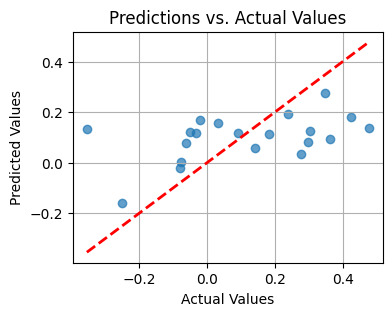

In [210]:
# testing ridge regression
print(ridgeBest.score(test[factors], test["btc"]))
plot_pred(test["btc"], ridgeBest.predict(test[factors]), figsize=(4,3))

In [212]:
# applying elastic net  
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet()

clf = GridSearchCV(elasticNet, tuned_parameters, cv=5, refit=True)
clf.fit(train[factors], train["btc"])
netBest = clf.best_estimator_

print(factors)
print(netBest.alpha)
print(netBest.coef_)

Index(['spy', 'iau', 'rf', 'by', 'cpi', 'm1'], dtype='object')
0.0019630406500402682
[ 0.54592525  0.         -0.00426448  0.          0.05323497 -0.        ]


0.13120738948208255


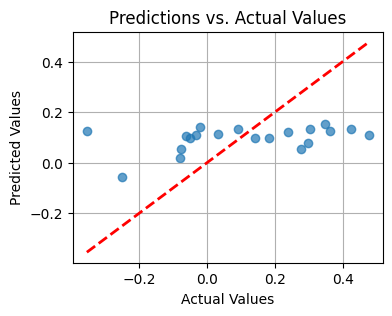

In [213]:
# testing elastic net
print(netBest.score(test[factors], test["btc"]))
plot_pred(test["btc"], netBest.predict(test[factors]), figsize=(4,3))